<a href="https://colab.research.google.com/github/nebojsa-bozanic/OSuM/blob/master/OSuM_Vezba7/OSuM_Vezba7/OSuM_vezba_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Obrada slike u medicini (BMI)</h1>

Literatura: https://moodle.telekom.ftn.uns.ac.rs/course/view.php?id=82


Laboratorijska vežba 7: Obrada rendgenske slike: Suzbijanje šuma 1

Potrebne biblioteke: cv2, numpy, matplotlib.pyplot, scipy.ndimage.filters (convolve1d, convolve), medpy.filter.smoothing (anisotropic_diffusion), osum

In [23]:
!git clone https://github.com/nebojsa-bozanic/OSuM.git
%cd /content/OSuM/OSuM_Vezba7/OSuM_Vezba7

Cloning into 'OSuM'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 323 (delta 12), reused 30 (delta 12), pack-reused 293
Receiving objects: 100% (323/323), 192.68 MiB | 14.19 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Checking out files: 100% (136/136), done.
/content/OSuM/OSuM_Vezba7/OSuM_Vezba7


In [24]:
!pip install medpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import osum
from scipy.ndimage.filters import convolve1d, convolve
from medpy.filter.smoothing import anisotropic_diffusion

from google.colab.patches import cv2_imshow

1 Razdvojivi 2D NF filtar

1.1 Učitati sliku lspine_crop.png u promenljivu im1.

In [26]:
im1 = cv2.imread('lspine_crop.png', cv2.IMREAD_GRAYSCALE)

1.2 Koristeći funkciju gaussian iz modula osum.py napraviti 1D Gausov filtar sa
proizvoljnim n i sigma (npr. n=19, sigma =3).

In [27]:
n = 19
sigma = 3
f, x_osa = osum.gaussian(n, sigma)

1.3 Prikazati 1D filtar, a zatim prikazati 2D filtar H koji se dobija vektorskim množenjem
dva 1D filtra.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


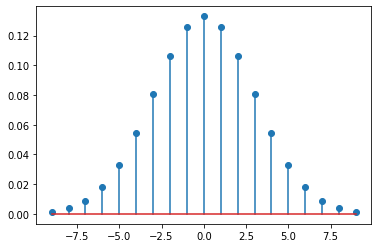

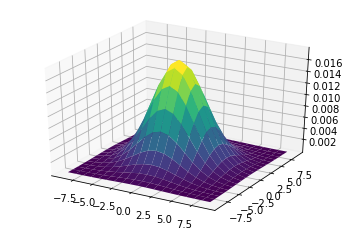

In [28]:
plt.figure()
plt.stem(x_osa, f)
# plt.show()

H = np.outer(f,f)
fig = plt.figure()
ax = plt.axes(projection='3d')
[x,y] = np.meshgrid(x_osa, x_osa)
ax.plot_surface(x, y, H, cmap='viridis')
plt.show()


1.4 Isfiltrirati sliku im1 1D gausovim filtrom prvo po jednoj dimenziji, a zatim po drugoj. Gausov filtar je razdvojiv filtar, pa je ovo ekvivalentno direktnom filtriranju sa 2D filtrom. Koja je prednost filtriranja 1D filtrima u odnosu na 2D filtar?


In [29]:
im_f1 = convolve1d(im1, f, axis=0, mode='nearest')
im_f1 = convolve1d(im_f1, f, axis=1, mode='nearest')

1.5 Prikazati sliku nakon filtriranja i uporediti je sa originalnom. Koji je efekat filtriranja na šum, a koji na ivice.

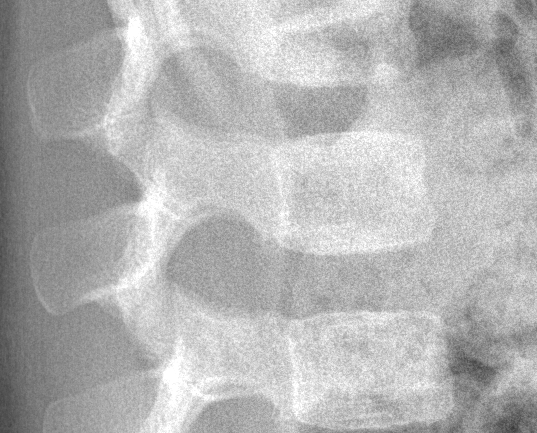

In [30]:
cv2_imshow(im1) # 'Originalna slika', 

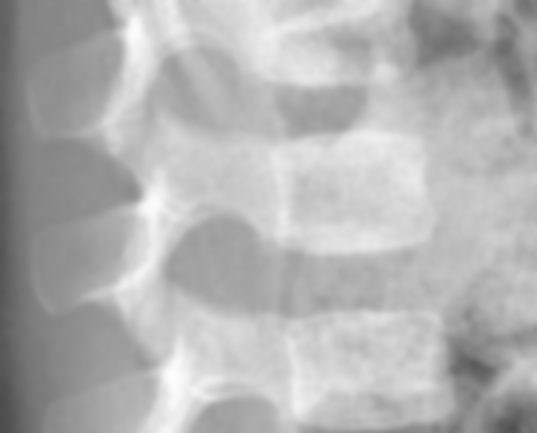

In [31]:
cv2_imshow(im_f1) # 'NF filtrirana', 

1.6 Ponoviti prethodne korake za različite kombinacije n i sigma. Koji je efekat kada se koriste veće, a koji kada se koriste manje vrednosti n, odnosno sigma?

In [32]:
# n = 11
# sigma = 1.5

1.7 Ponoviti prethodne korake sa slikom lspine.png učitanom u promenljivu im11.

In [33]:
im11 = cv2.imread('lspine.png', cv2.IMREAD_GRAYSCALE)

2 Usmereno filtriranje

2.1 Od filtra H napraviti usmereni filtar H1 koji prati ivice. Prikazati ga.

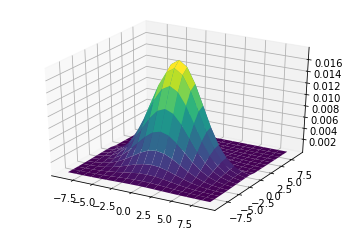

In [34]:
H2 = H
ind = int(np.ceil(n/2))
H2[ind:, :] = H2[ind:, :]*0.1

fig = plt.figure()
ax = plt.axes(projection='3d')
[x,y] = np.meshgrid(x_osa, x_osa)
ax.plot_surface(x, y, H2, cmap='viridis')
plt.show()

2.2 Primeniti filtar na sliku im1 i prikazati je. Uporediti je sa slikom slikom isfiltriranom
prethodnim filtrom. Isto uraditi i sa slikom im11. Zašto slika izgleda tamnije?

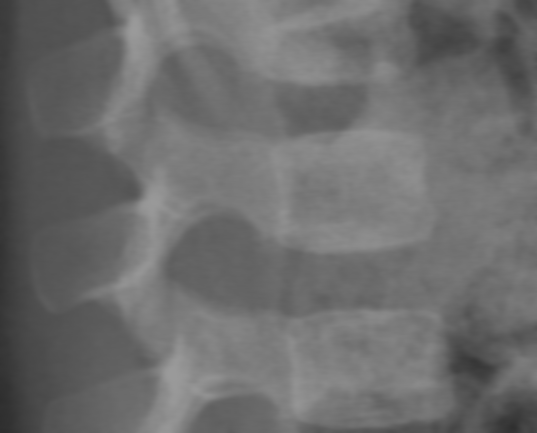

In [35]:
im_f2 = convolve(im1, H, mode='nearest')
cv2_imshow(im_f2) # 'Usmereno filtriranje', 

3 Anizotropski filtar

U promenljivu im2 učitati sliku abdomen_crop.png i isfiltrirati je funkcijom
anisotropic_diffusion. Inicijalno postaviti parametre niter=5 i kappa=100. Menjati parametre i analizirati efekte. Prikazati isfiltriranu sliku.

/usr/local/lib/python3.7/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.7/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


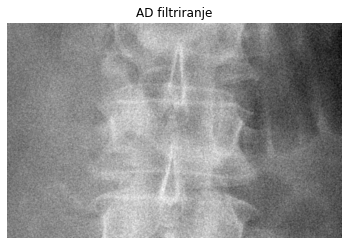

In [36]:
im2 = cv2.imread('abdomen_crop.png', cv2.IMREAD_GRAYSCALE)
im_f3 = anisotropic_diffusion(im2, niter=5, kappa=100)
# manje kappa->manji gradijent sprecava provodjenje->difuzija kroz manji prostor, manje se usrednjava

plt.figure()
plt.imshow(im_f3, cmap='gray', vmin=im_f3.min(), vmax=im_f3.max())
plt.axis('off')
plt.title('AD filtriranje')
plt.show()

4 Bilateralni filtar


Primeniti bilateralni filtar na sliku im2. Inicijalno postaviti parametre velicina prozora d=15, std prostornog kernela sigmaSpace=15, std kernela za intenzitet sigmaColor=15. Isprobati različite kombinacije parametara i analizirati efekte. Uraditi isto sa slikom abdomen.png učitanom u promenljivu im22.

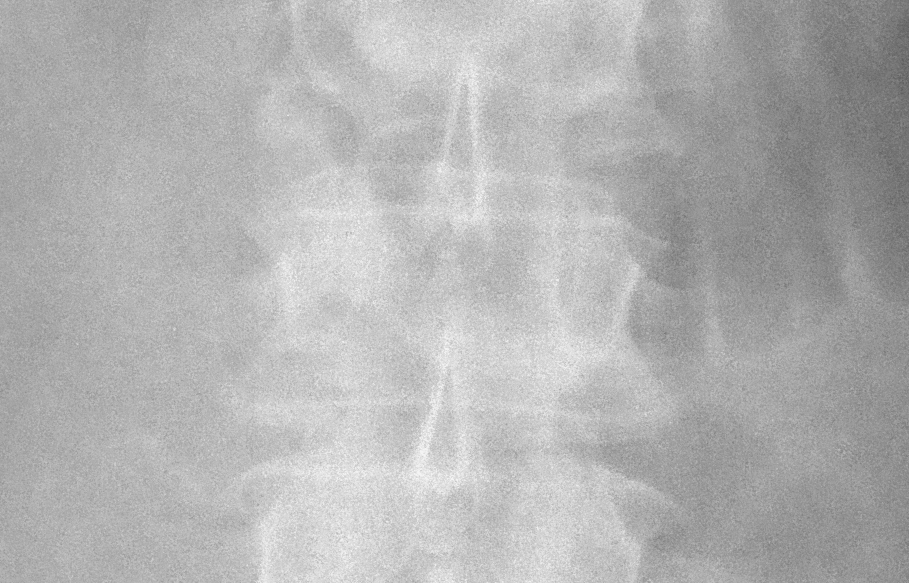

In [37]:
im22 = cv2.imread('abdomen.png', cv2.IMREAD_GRAYSCALE)
im_f4 = cv2.bilateralFilter(im2, d=15, sigmaSpace=15, sigmaColor=15)
# im_f4 = cv2.bilateralFilter(im2, d=15, sigmaSpace=15, sigmaColor=75)

cv2_imshow(im_f4) # 'Bilateralno filtriranje', 

5. Multiveličinsko filtriranje 

Skraćivanje u piramidi

5.1 Napraviti Laplasovu piramidu sa 2 nivoa od slike im2. Prikazati histogram 
prvog nivoa
LP u granicama -200 do 200.

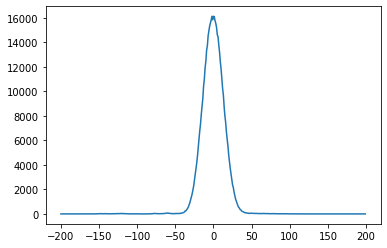

In [38]:
Lpyr, Gpyr, Res, size_vec = osum.im_pyr_decomp(im2, 2)
L1 = Lpyr[0]
# L2 = Lpyr[1]  # 5.5

g = np.arange(-200, 201)
h1 = np.histogram(L1, g)
plt.figure()
plt.plot(g[:-1], h1[0])
# plt.show()

5.2 Skraćivanje piramide se radi na višim nivoima piramida slike uz pretpostavku da na tim nivoima dominira šum, pa želimo da smanjimo kontrast, tj. vidljivost šuma. Vrednosti svih koeficijenata smanjujemo (skraćujemo) za vrednost cs (inicijalno postaviti na 15). Koeficijente koji su po apsolutnoj vrednosti manji od cs treba svesti na 0.

In [39]:
cs = 15  # cs = 20, cs = 10, cs = 5  # 5.5
L1[L1>0] = np.maximum(L1[L1>0]-cs, 0)
L1[L1<0] = np.minimum(L1[L1<0]+cs, 0)

5.3 Napraviti histogram prvog nivoa LP nakon skraćivanja i prikazati ga preko histograma originalnog nivoa.

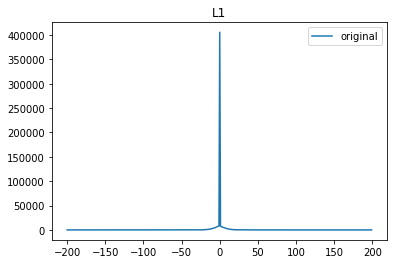

In [40]:
h2 = np.histogram(L1, g)
plt.plot(g[:-1], h2[0])
plt.legend(['original', 'skracivanje'])
plt.title('L1')
plt.show()

5.4 Prikazati sliku pre i posle skraćivanja i uporediti ih.

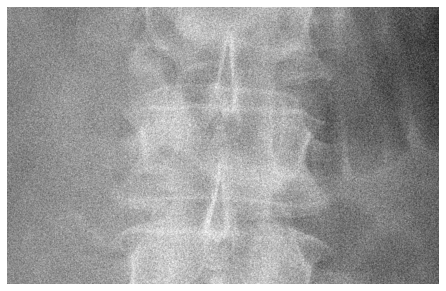

In [41]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im2, cmap='gray', vmin=im2.min(), vmax=im2.max())
plt.axis('off')
fig.canvas.set_window_title('Originalna slika')

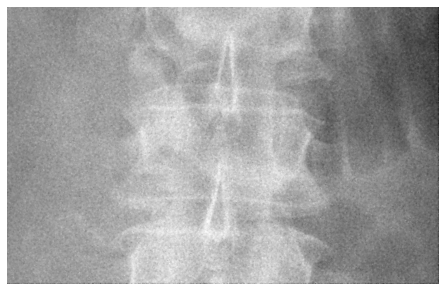

In [42]:
Lpyr[0] = L1
im_r1 = osum.im_pyr_recon(Lpyr, Res, size_vec)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im_r1, cmap='gray', vmin=im_r1.min(), vmax=im_r1.max())
plt.axis('off')
fig.canvas.set_window_title('Nakon skracivanja u piramidi')
plt.show()


5.5 Menjati vrednosti cs (odabrati vrednosti analizom histograma) i analizirati efekte. Isprobati skraćivanje i na drugi nivou LP.

5.6 Ponoviti sve korake za sliku im22.
Pragovanje u piramidi

5.7 Pragovanje se iz istog razloga kao i skraćivanje radi na višim nivoima piramide.
Koeficijente koji su po apsolutnoj vrednosti manji od praga t treba svesti na 0.
Inicijalno uzeti t=15.

In [43]:
Lpyr, Gpyr, Res, size_vec = osum.im_pyr_decomp(im2, 2)
L1 = Lpyr[0]

g = np.arange(-200, 201)
h1 = np.histogram(L1, g)

t = 15
L1[abs(L1)<t] = L1[abs(L1)<t]*0

5.8 Prikazati histograme pre i posle pragovanja.

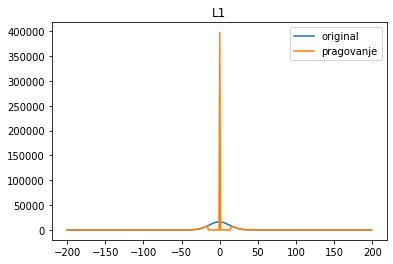

In [44]:
h2 = np.histogram(L1, g)
plt.figure()
plt.plot(g[:-1], h1[0])
plt.plot(g[:-1], h2[0])
plt.legend(['original', 'pragovanje'])
plt.title('L1')
plt.show()

5.9 Prikazati slike pre i posle pragovanja.

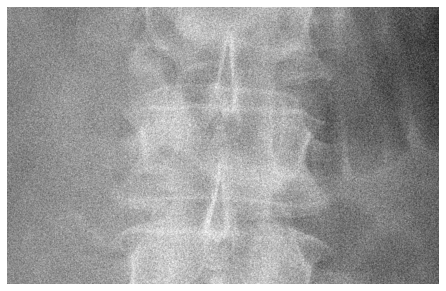

In [45]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im2, cmap='gray', vmin=im2.min(), vmax=im2.max())
plt.axis('off')
fig.canvas.set_window_title('Originalna slika')

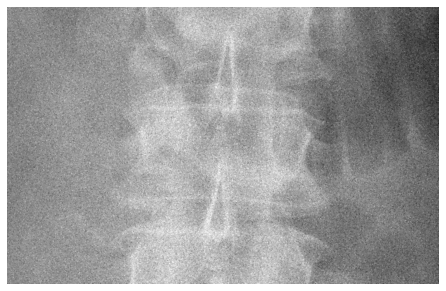

In [46]:
Lpyr[0] = L1
im_r2 = osum.im_pyr_recon(Lpyr, Res, size_vec)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im_r2, cmap='gray', vmin=im_r2.min(), vmax=im_r2.max())
plt.axis('off')
fig.canvas.set_window_title('Nakon pragovanja u piramidi')
plt.show()

5.10 Isporbati različite vrednosti za prag t (odabrati vrednosti analizom histograma)
kao i za drugi nivo LP i analizirati efekte. Ponoviti sve korake za sliku im22.